# Model Development

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Replace with the path to Chicago dataset
chicago_filepath = "Chicago_after_FE.csv"
# Replace with the path to NIBRS test dataset
NIBRS_filepath = "NIBRS_after_FE.csv"

# Read the dataset
chicago_df = pd.read_csv(chicago_filepath)
NIBRS_df = pd.read_csv(NIBRS_filepath)

/var/folders/rm/zkx7tx614cq0pcwp0cpgbhy80000gn/T/ipykernel_40163/3116578832.py:8: DtypeWarning: Columns (8,9,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  NIBRS_df = pd.read_csv(NIBRS_filepath)


In [4]:
# Check Date Range
c_min_date = chicago_df['date'].min()
c_max_date = chicago_df['date'].max()
n_min_date = NIBRS_df['date'].min()
n_max_date = NIBRS_df['date'].max()
print(f"Chicago Dataset Date Range: {c_min_date} to {c_max_date}")
print(f"NIBRS Dataset Date Range: {n_min_date} to {n_max_date}")

Chicago Dataset Date Range: 2020-07-31 17:29:00 to 2025-03-16 03:00:00
NIBRS Dataset Date Range: 2023-01-01 00:00:00 to 2023-12-31 23:00:00


In [5]:
chicago_df['date'] = pd.to_datetime(chicago_df['date'])
# Choose data from 2021-01-01 to 2022-12-31 for model training and initial testing
filtered_df = chicago_df[(chicago_df['date'] >= '2021-01-01') & (chicago_df['date'] <= '2022-12-31')]

print(f"Chicago Dataset Date Range After Filtering: {filtered_df['date'].min()}, {filtered_df['date'].max()}")

Chicago Dataset Date Range After Filtering: 2021-01-01 00:00:00, 2022-12-31 00:00:00


In [6]:
chicago_df = filtered_df
print("Chicago dataset shape:", chicago_df.shape)

Chicago dataset shape: (448489, 32)


In [7]:
NIBRS_df.shape

(562976, 37)

## Feature Processing

In [8]:
feature_columns = [
    'arrest', 'UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday', 
    'is_weekend', 'is_holiday', 'crime_against', 'offense_category_name'
]

chicago_df = chicago_df[feature_columns]

In [9]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


## Model Training

### Perceptron Classifier 
The Perceptron, as a single-layer neural network, was selected for this arrest prediction task due to its distinct advantages in handling the given feature space (crime type, time, and location) and its fundamental algorithmic differences from the previously attempted CatBoost model.  

**Key Justifications:**  
1. **Linear Separability Prioritization**  
   - Given that arrest decisions may rely on threshold-based patterns (e.g., specific crime types or locations triggering higher arrest probabilities), the Perceptron’s linear decision boundary can efficiently capture such deterministic rules. Unlike tree-based models that partition feature space hierarchically, the Perceptron directly learns a hyperplane, potentially revealing simpler but legally actionable decision patterns.  

2. **Temporal Feature Efficiency**  
   - Time-based features (e.g., hour of day, day of week) often exhibit cyclical linear relationships with arrest rates (e.g., higher arrests during nighttime). The Perceptron’s weight-based learning mechanism can explicitly quantify these periodic trends through learned coefficients, whereas tree models may over-fragment temporal patterns.  

3. **Computational Scalability**  
   - For a dataset with spatially dense location data (e.g., latitude/longitude coordinates), the Perceptron’s O(*n*) training complexity outperforms ensemble methods when processing high-frequency updates. This aligns with real-world policing needs where rapid model retraining may be required.  

4. **Interpretability Trade-off**  
   - While less interpretable than decision trees, the Perceptron’s weights provide direct feature importance metrics (e.g., high-magnitude weights for violent crime types). This offers a middle ground between CatBoost’s complex feature interactions and purely linear models like logistic regression.  

## Imbalanced data
For `arrest` feature, it is extremely imbalanced with highly unarrested proportion.

For `Perception` model, we will use `SGDClassifier` with `log` loss function. The `log` loss function is used for binary classification problems and is suitable for our task of predicting arrests. The `SGDClassifier` is a linear classifier that uses stochastic gradient descent to optimize the model parameters. It is efficient for large datasets and can handle online learning scenarios.


In [10]:
# Define feature types
numeric_features = ['UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday']
binary_features = ['is_weekend', 'is_holiday']
categorical_features = ['crime_against', 'offense_category_name']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('binary', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Define the model pipeline
# Using SGDClassifier with log loss for binary classification
# SGDClassifier is a linear classifier that uses stochastic gradient descent
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='log',
        class_weight={False: 2, True: 8},  
        penalty='l2',
        alpha=0.001,
        # class_weight='balanced',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

# Split the data into features and target variable
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)


y_scores = model.decision_function(X_test)

# Optimal threshold calculation based on F1 score
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
# print("original performance\n", "Precision: ", precision, "Recall: ",recall,"thresholds: ", thresholds)

optimal_idx = np.argmax(2 * precision * recall / (precision + recall))  # F1 score 
optimal_threshold = thresholds[optimal_idx]

# Optimal threshold
print("Optimal Threshold:", optimal_threshold)
y_pred_optimized = (y_scores > optimal_threshold).astype(int)


print("Classification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_optimized))

print("\nConfusion Matrix (Optimized Threshold):")
print(confusion_matrix(y_test, y_pred_optimized))

Optimal Threshold: 0.5686959523903101
Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

       False       0.93      0.97      0.95     78768
        True       0.69      0.46      0.55     10930

    accuracy                           0.91     89698
   macro avg       0.81      0.72      0.75     89698
weighted avg       0.90      0.91      0.90     89698


Confusion Matrix (Optimized Threshold):
[[76502  2266]
 [ 5911  5019]]


In [ ]:
import joblib

# Save the trained model to a file
model_filename = "Model_Location.pkl"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

"""
Test the saved model with the NIBRS dataset (for merged testing)

# Load the model from the file
loaded_model = joblib.load(model_filename)
print("Model loaded from file.")
# Test the loaded model with the test set
y_pred_loaded = loaded_model.predict(X_test)
print("Loaded Model Classification Report:")
"""

Model saved to Model_Location.pkl


### Optimize Parameters
TODO: with my local limited computational resources, it's hard to train :(

In [12]:
# param_dist = {
#     'depth': [4, 6],
#     'learning_rate': [0.03, 0.05],
#     'l2_leaf_reg': [3, 5, 7],
#     'scale_pos_weight': [arrest_weight, arrest_weight * 1.5],
#     'border_count': [32, 64]
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='f1',
#     cv=2,
#     verbose=1,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best Params:", random_search.best_params_)

## Test Model In NIBRS

In [13]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,Person,Assault Offenses
1,True,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property
2,True,1,4,13,13,3,0,0,Person,Assault Offenses
3,True,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses
4,True,1,5,20,15,5,1,0,Person,Assault Offenses


In [14]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [15]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest']) 
y_NIBRS_test = NIBRS_df['arrest']

In [16]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.97      0.91    467171
        True       0.63      0.28      0.39     95805

    accuracy                           0.85    562976
   macro avg       0.75      0.62      0.65    562976
weighted avg       0.83      0.85      0.82    562976



# Model Evaluation

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

## Standard Classification Metrics

In [18]:
print("Chicago Classification Report:\n", classification_report(y_test, y_pred_optimized))
print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

Chicago Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.97      0.95     78768
        True       0.69      0.46      0.55     10930

    accuracy                           0.91     89698
   macro avg       0.81      0.72      0.75     89698
weighted avg       0.90      0.91      0.90     89698

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.97      0.91    467171
        True       0.63      0.28      0.39     95805

    accuracy                           0.85    562976
   macro avg       0.75      0.62      0.65    562976
weighted avg       0.83      0.85      0.82    562976



In [19]:
# calculate ROC AUC score
# for Chicago test set
y_proba = model.predict_proba(X_test)[:, 1]
c_auc_score = roc_auc_score(y_test, y_proba)
print("Chicago ROC-AUC Score:", c_auc_score)

# for NIBRS test set
y_NIBRS_proba = model.predict_proba(X_NIBRS_test)[:, 1]
n_auc_score = roc_auc_score(y_NIBRS_test, y_NIBRS_proba)
print("NIBRS ROC-AUC Score:", n_auc_score)

Chicago ROC-AUC Score: 0.8216656437081652
NIBRS ROC-AUC Score: 0.7226734798725508


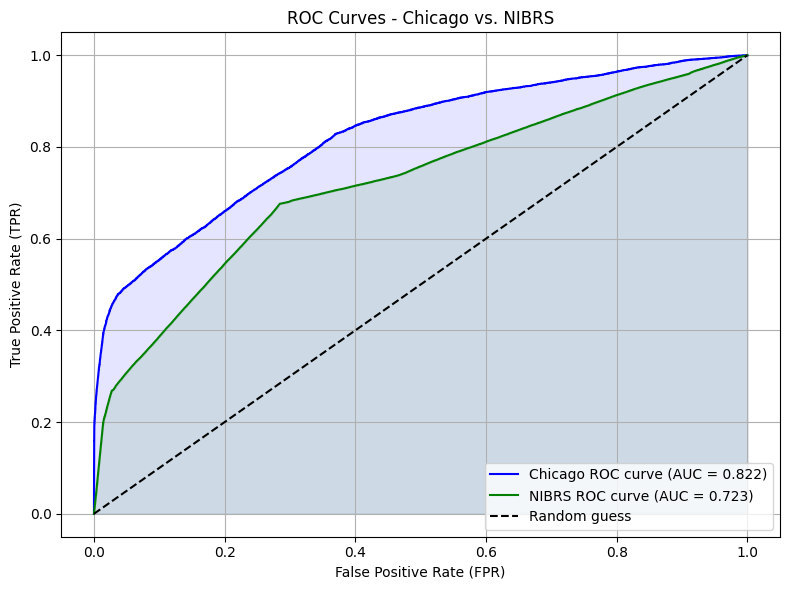

In [20]:
# Plot ROC Curves
fpr_c, tpr_c, _ = roc_curve(y_test, y_proba)
auc_c = roc_auc_score(y_test, y_proba)
fpr_n, tpr_n, _ = roc_curve(y_NIBRS_test, y_NIBRS_proba)
auc_n = roc_auc_score(y_NIBRS_test, y_NIBRS_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, label=f'Chicago ROC curve (AUC = {auc_c:.3f})', color='blue')
plt.plot(fpr_n, tpr_n, label=f'NIBRS ROC curve (AUC = {auc_n:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.fill_between(fpr_c, tpr_c, alpha=0.1, color='blue')
plt.fill_between(fpr_n, tpr_n, alpha=0.1, color='green')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves - Chicago vs. NIBRS')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Temporal Accuracy Measures

In [21]:
def concat_eval_df(X_test, y_test, y_pred):
    eval_df = X_test.reset_index(drop=True).copy()

    eval_df['y_true'] = pd.Series(y_test).reset_index(drop=True)
    eval_df['y_pred'] = pd.Series(y_pred).reset_index(drop=True)

    return eval_df

In [22]:
# Create evaluation DataFrame for Chicago test set
eval_df_chicago = concat_eval_df(X_test, y_test, y_pred_optimized)

# Create evaluation DataFrame for NIBRS test set
eval_df_NIBRS = concat_eval_df(X_NIBRS_test, y_NIBRS_test, y_NIBRS_pred)

In [23]:
eval_df_chicago.head()

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name,y_true,y_pred
0,10,9,18,10,5,1,0,Person,Assault Offenses,False,0
1,1,4,30,22,5,1,0,Person,Assault Offenses,False,0
2,2,6,12,8,6,1,0,Property,Larceny/Theft Offenses,False,0
3,2,6,17,11,4,0,0,Person,Assault Offenses,False,0
4,1,5,28,0,5,1,0,Person,Assault Offenses,False,0


In [24]:
eval_df_NIBRS.head()

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name,y_true,y_pred
0,1,1,19,21,3,0,0,Person,Assault Offenses,True,False
1,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property,True,False
2,1,4,13,13,3,0,0,Person,Assault Offenses,True,False
3,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses,True,True
4,1,5,20,15,5,1,0,Person,Assault Offenses,True,False


In [25]:
def evaluate_temporal_performance(df, group_col, y_true_col='y_true', y_pred_col='y_pred'):
    grouped_perf = df.groupby(group_col).apply(
        lambda g: pd.Series({
            'accuracy': accuracy_score(g[y_true_col], g[y_pred_col]),
            'f1_score': f1_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'precision': precision_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'recall': recall_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'count': len(g)
        })
    ).reset_index()

    return grouped_perf

In [26]:
# Note: df1 is for Chicago, df2 is for NIBRS
def plot_temporal_comparison(df1, df2, x_col, dataset_names=('Chicago', 'NIBRS'), title_prefix=''):

    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    titles = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

    df1 = df1.sort_values(by=x_col)
    df2 = df2.sort_values(by=x_col)
    x_vals = df1[x_col]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axs[row][col]

        ax.plot(x_vals, df1[metric], marker='o', label=dataset_names[0], color='blue')
        ax.plot(x_vals, df2[metric], marker='s', label=dataset_names[1], color='green', linestyle='--')

        ax.set_title(f'{titles[i]} by {x_col.capitalize()}', fontsize=12)
        ax.set_xlabel(x_col.capitalize())
        ax.set_ylabel(titles[i])
        ax.set_xticks(sorted(x_vals.unique()))
        ax.grid(True)
        ax.legend()

    plt.suptitle(f'{title_prefix} Performance Comparison: {dataset_names[0]} vs {dataset_names[1]}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [27]:
def plot_binary_group_bars_split(df1, df2, group_col='is_weekend', dataset_names=('Chicago', 'NIBRS'), title_prefix=''):
    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    df1 = df1.sort_values(by=group_col)
    df2 = df2.sort_values(by=group_col)

    categories = sorted(df1[group_col].unique())  # e.g. [0, 1]
    bar_width = 0.2
    x = np.arange(len(categories))
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

    for i, metric in enumerate(metrics):
        ax = axs[i]
        
        df1_scores = df1.set_index(group_col)[metric].loc[categories]
        df2_scores = df2.set_index(group_col)[metric].loc[categories]

        ax.bar(x - bar_width/2, df1_scores, width=bar_width, label=dataset_names[0], color='blue')
        ax.bar(x + bar_width/2, df2_scores, width=bar_width, label=dataset_names[1], color='green', hatch='//')

        ax.set_title(metric.title(), fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels([f'{group_col}={c}' for c in categories])
        ax.set_ylim(0, 1)
        ax.set_ylabel("Score")
        ax.grid(axis='y')
        if i == 0:
            ax.legend()

    plt.suptitle(f'{title_prefix} Performance by {group_col}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

### Evaluate Performance in Hour

In [28]:
# Evaluate performance in Hour for Chicago test set
hourly_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='hour')
print("Performance in Hour for Chicago test set: \n", hourly_perf_chicago)
# Evaluate performance in Hour for NIBRS test set
hourly_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='hour')
print("Performance in Hour for NIBRS test set: \n", hourly_perf_NIBRS)

Performance in Hour for Chicago test set: 
     hour  accuracy  f1_score  precision    recall   count
0      0  0.920834  0.479857   0.617512  0.392387  7339.0
1      1  0.867171  0.381410   0.468504  0.321622  2906.0
2      2  0.867193  0.309198   0.389163  0.256494  2658.0
3      3  0.893394  0.286585   0.328671  0.254054  2195.0
4      4  0.889079  0.236220   0.294118  0.197368  1749.0
5      5  0.907652  0.285714   0.394366  0.224000  1516.0
6      6  0.916454  0.276243   0.396825  0.211864  1568.0
7      7  0.916511  0.389078   0.600000  0.287879  2144.0
8      8  0.921932  0.401015   0.681034  0.284173  3023.0
9      9  0.925993  0.507719   0.747475  0.384416  3878.0
10    10  0.922433  0.651481   0.819484  0.540643  3945.0
11    11  0.916624  0.697588   0.852608  0.590267  3910.0
12    12  0.930441  0.636000   0.787129  0.533557  5233.0
13    13  0.914495  0.609730   0.748011  0.514599  4222.0
14    14  0.919914  0.600715   0.745562  0.502994  4183.0
15    15  0.923826  0.547739

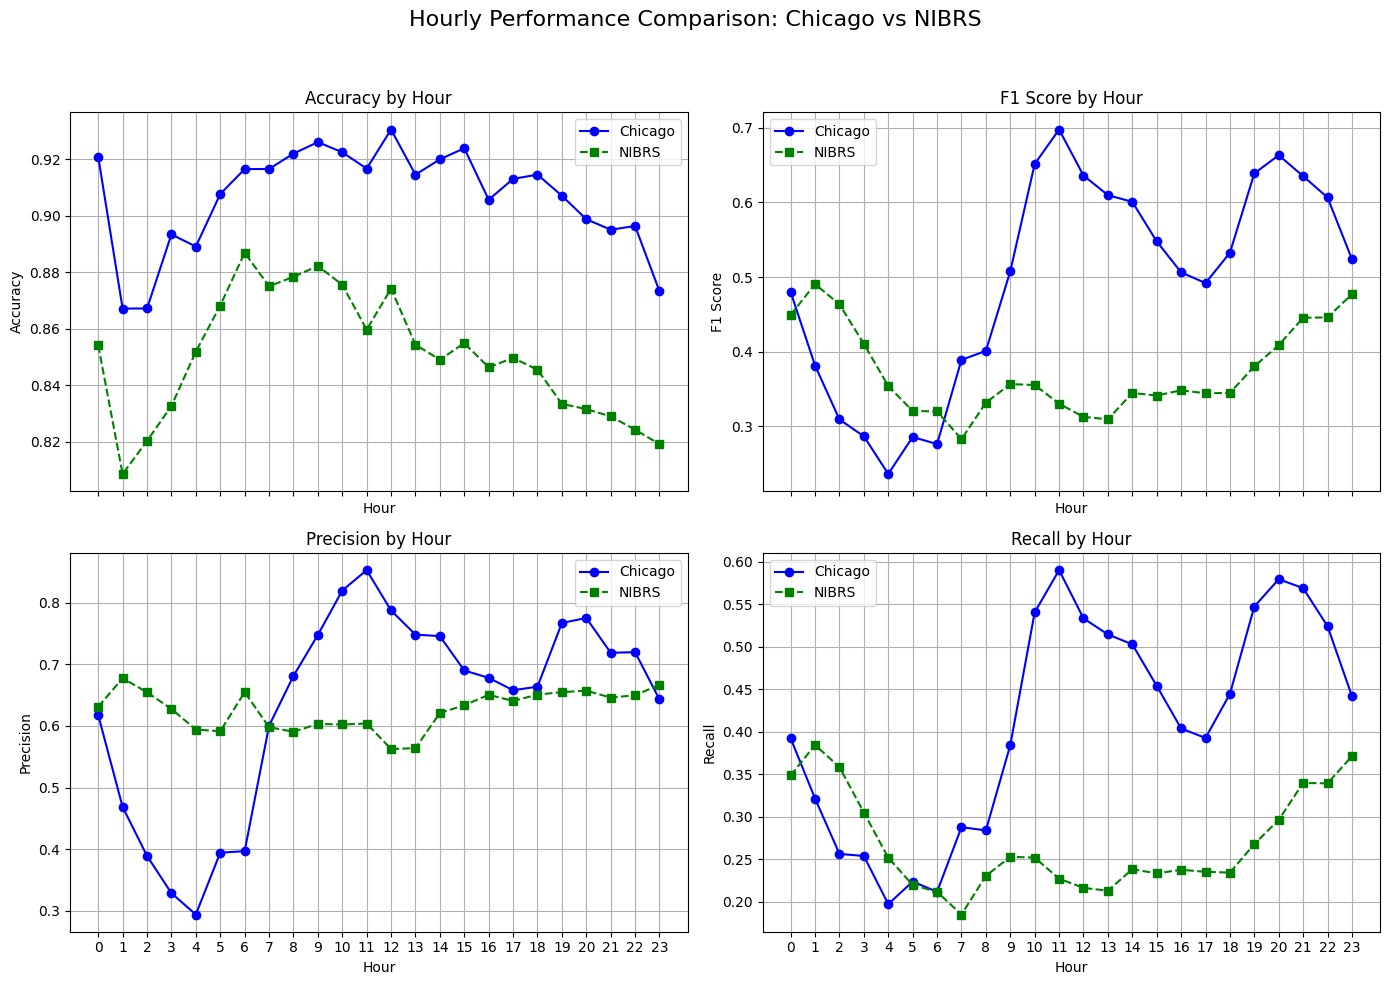

In [29]:
hourly_perf_chicago = hourly_perf_chicago.sort_values(by='hour')
hourly_perf_NIBRS = hourly_perf_NIBRS.sort_values(by='hour')

hours = hourly_perf_chicago['hour']

plot_temporal_comparison(
    hourly_perf_chicago, 
    hourly_perf_NIBRS, 
    x_col='hour', 
    dataset_names=('Chicago', 'NIBRS'), 
    title_prefix='Hourly'
)

### Evaluate Performance in Month

In [30]:
# Evaluate performance in Month for Chicago test set
monthly_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='month')
print("Performance in Month for Chicago test set: \n", monthly_perf_chicago)
# Evaluate performance in Month for NIBRS test set
monthly_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='month')
print("Performance in Month for NIBRS test set: \n", monthly_perf_NIBRS)

Performance in Month for Chicago test set: 
     month  accuracy  f1_score  precision    recall   count
0       1  0.905788  0.565627   0.673575  0.487500  6358.0
1       2  0.893753  0.599060   0.753378  0.497213  5619.0
2       3  0.896986  0.606530   0.718218  0.524904  6902.0
3       4  0.900833  0.577045   0.682159  0.500000  6726.0
4       5  0.893631  0.559697   0.696237  0.467931  7662.0
5       6  0.912215  0.577805   0.688218  0.497921  7974.0
6       7  0.909069  0.532911   0.643731  0.454644  8116.0
7       8  0.911871  0.497253   0.636204  0.408117  8306.0
8       9  0.915807  0.524129   0.669521  0.430617  8433.0
9      10  0.924177  0.534950   0.730994  0.421822  8599.0
10     11  0.918786  0.524438   0.701245  0.418835  7548.0
11     12  0.913749  0.479352   0.669683  0.373266  7455.0
Performance in Month for NIBRS test set: 
     month  accuracy  f1_score  precision    recall    count
0       1  0.851153  0.407593   0.622550  0.302979  45288.0
1       2  0.847461  0.42

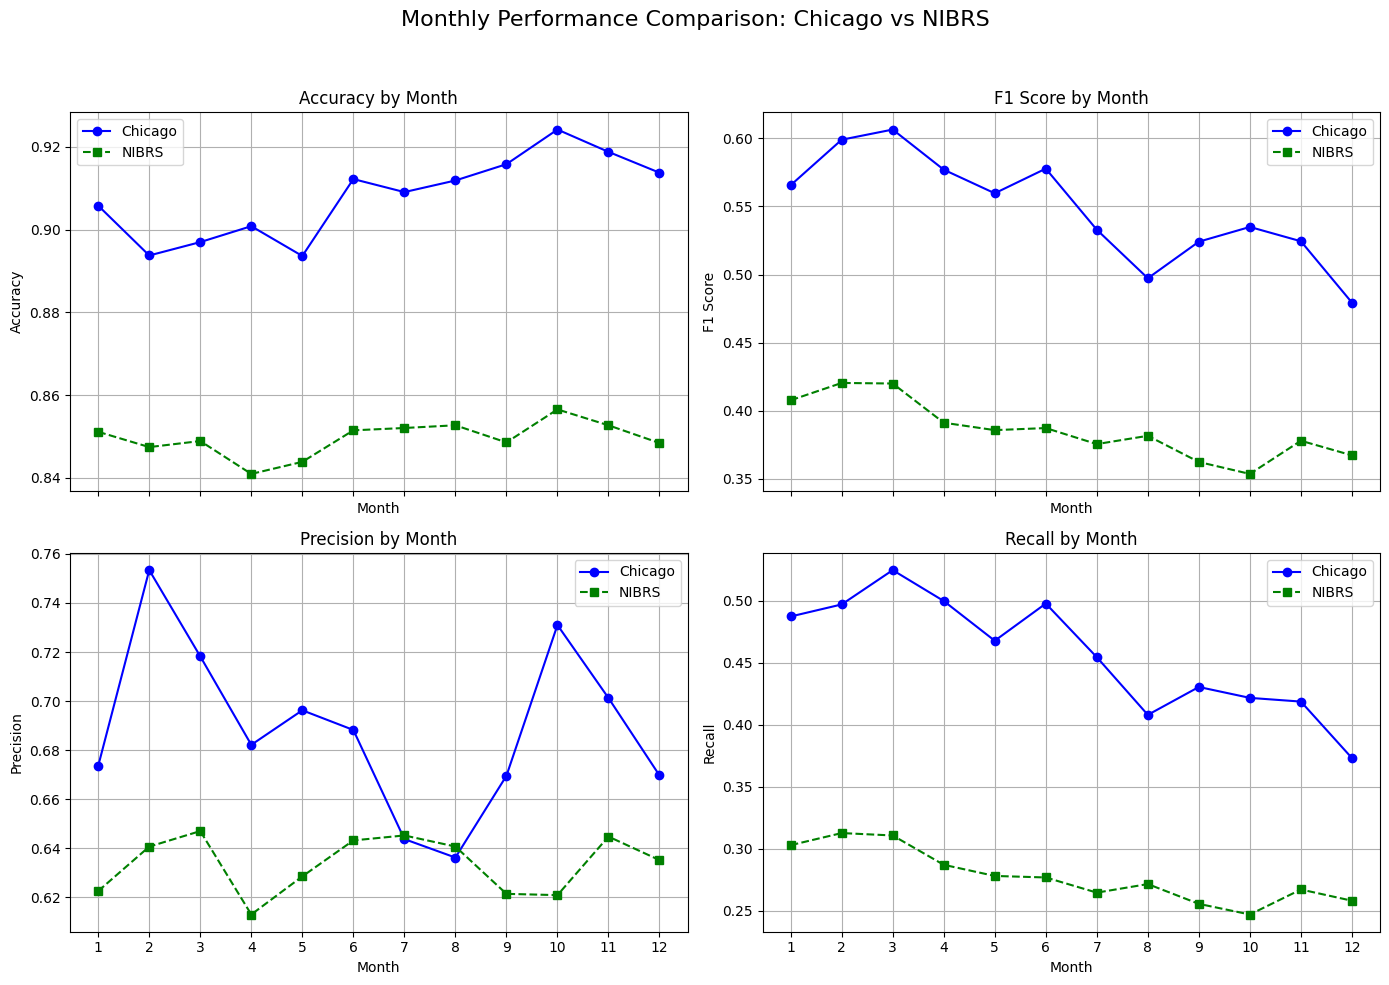

In [31]:
monthly_perf_chicago = monthly_perf_chicago.sort_values(by='month')
monthly_perf_NIBRS = monthly_perf_NIBRS.sort_values(by='month')

months = monthly_perf_chicago['month']

plot_temporal_comparison(
    monthly_perf_chicago, 
    monthly_perf_NIBRS, 
    x_col='month', 
    dataset_names=('Chicago', 'NIBRS'), 
    title_prefix='Monthly'
)

### Evaluate Performance in Weekend

In [32]:
# Evaluate performance in Month for Chicago test set
weekend_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='is_weekend')
print("Performance in is_weekend for Chicago test set: \n", weekend_perf_chicago)
# Evaluate performance in Month for NIBRS test set
weekend_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='is_weekend')
print("Performance in is_weekend for NIBRS test set: \n", weekend_perf_NIBRS)

Performance in is_weekend for Chicago test set: 
    is_weekend  accuracy  f1_score  precision    recall    count
0           0  0.912965  0.564283   0.708538  0.468831  64055.0
1           1  0.898530  0.519926   0.643379  0.436223  25643.0
Performance in is_weekend for NIBRS test set: 
    is_weekend  accuracy  f1_score  precision    recall     count
0           0  0.854971  0.392582    0.63052  0.285023  402457.0
1           1  0.836518  0.369637    0.64106  0.259687  160519.0


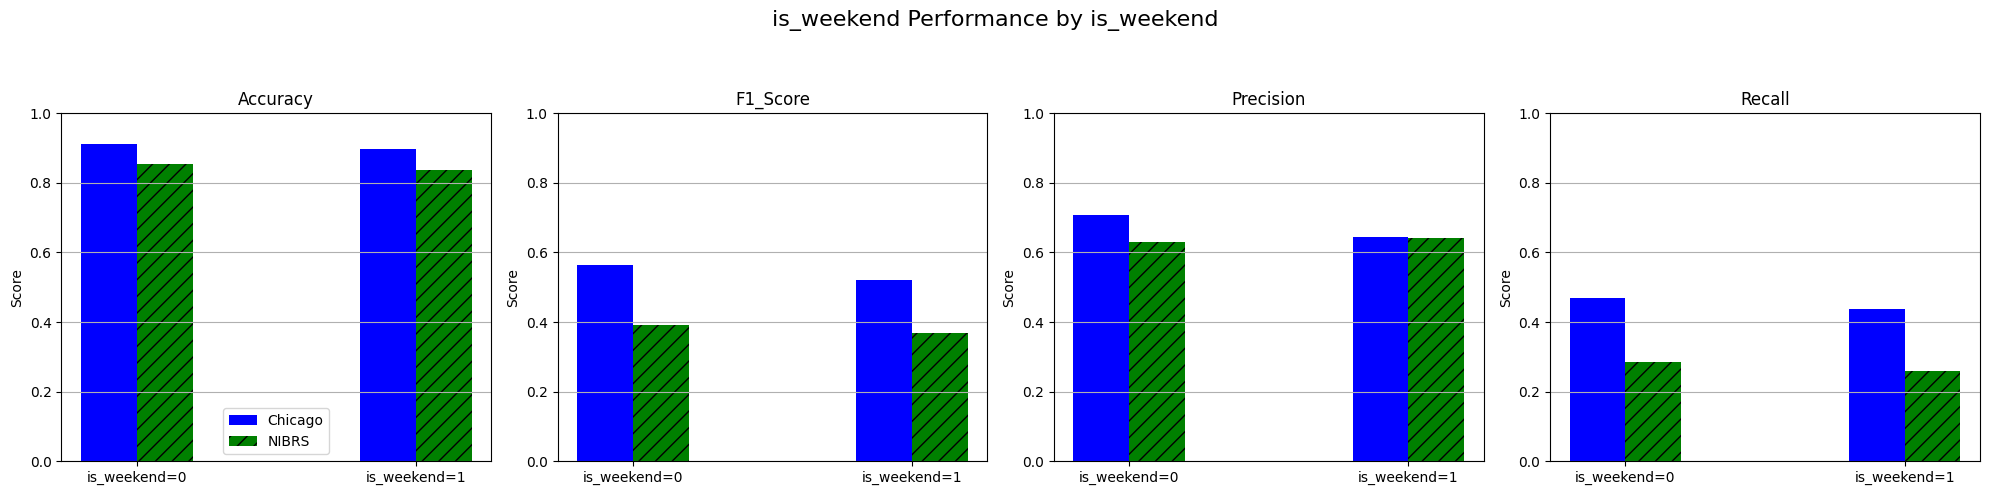

In [33]:
weekend_perf_chicago = weekend_perf_chicago.sort_values(by='is_weekend')
weekend_perf_NIBRS = weekend_perf_NIBRS.sort_values(by='is_weekend')

plot_binary_group_bars_split(
    weekend_perf_chicago, 
    weekend_perf_NIBRS, 
    group_col='is_weekend', 
    dataset_names=('Chicago', 'NIBRS'), 
    title_prefix='is_weekend'
)

### Evaluate performance in is_holiday

In [34]:
# Evaluate performance in Holiday for Chicago test set
holiday_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='is_holiday')
print("Performance in is_holiday for Chicago test set: \n", holiday_perf_chicago)
# Evaluate performance in Holiday for NIBRS test set
holiday_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='is_holiday')
print("Performance in is_holiday for NIBRS test set: \n", holiday_perf_NIBRS)

Performance in is_holiday for Chicago test set: 
    is_holiday  accuracy  f1_score  precision    recall    count
0           0  0.908982  0.549463     0.6875  0.457588  86214.0
1           1  0.905281  0.586466     0.7200  0.494715   3484.0
Performance in is_holiday for NIBRS test set: 
    is_holiday  accuracy  f1_score  precision    recall     count
0           0  0.849883  0.386495   0.634333  0.277913  543510.0
1           1  0.844858  0.361792   0.610556  0.257057   19466.0


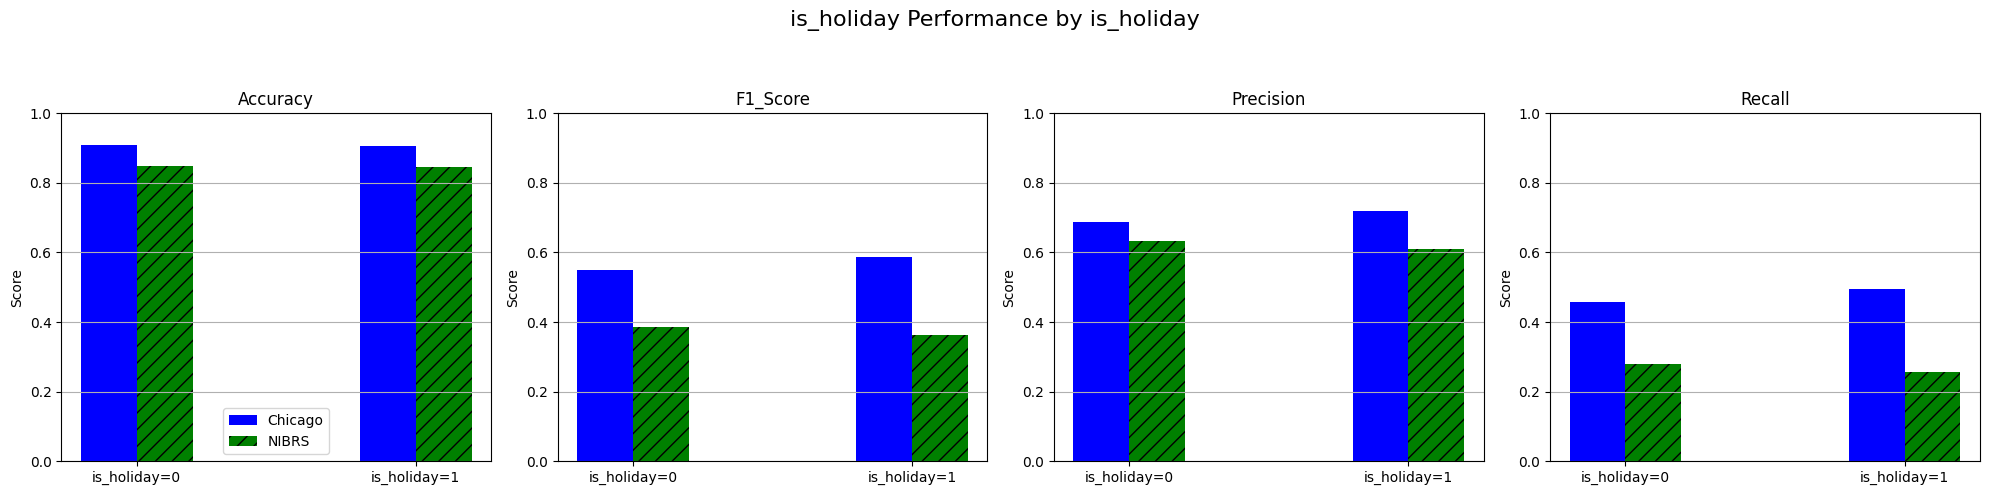

In [35]:
holiday_perf_chicago = holiday_perf_chicago.sort_values(by='is_holiday')
holiday_perf_NIBRS = holiday_perf_NIBRS.sort_values(by='is_holiday')

plot_binary_group_bars_split(
    holiday_perf_chicago, 
    holiday_perf_NIBRS, 
    group_col='is_holiday',
    dataset_names=('Chicago', 'NIBRS'), 
    title_prefix='is_holiday'
)

## Spatial Accuracy Evaluation

In [36]:
unified_location_mapping = {
    "Residence": 1,
    "Street/Outdoor": 2,
    "Transportation Hub": 3,
    "Retail/Commercial": 4,
    "Entertainment": 5,
    "Government/Public": 6,
    "Medical Facility": 7,
    "Workplace/Office": 8,
    "Parking Lot": 9,
    "Unknown/Other": 10
}
reverse_location_mapping = {v: k for k, v in unified_location_mapping.items()}

In [37]:
eval_df_chicago['location_name'] = eval_df_chicago['UNIFIED_LOCATION_CODE'].map(reverse_location_mapping)
eval_df_NIBRS['location_name'] = eval_df_NIBRS['UNIFIED_LOCATION_CODE'].map(reverse_location_mapping)

In [38]:
def evaluate_spatial_performance(df, group_col='location_name', y_true_col='y_true', y_pred_col='y_pred'):
    grouped_perf = df.groupby(group_col).apply(
        lambda g: pd.Series({
            'accuracy': accuracy_score(g[y_true_col], g[y_pred_col]),
            'f1_score': f1_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'precision': precision_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'recall': recall_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'count': len(g)
        })
    ).reset_index().sort_values(by='f1_score', ascending=False)
    
    return grouped_perf

In [39]:
def plot_spatial_performance_comparison(df1, df2, metric='f1_score', dataset_names=('Chicago', 'NIBRS')):

    merged = df1[['location_name', metric]].merge(
        df2[['location_name', metric]],
        on='location_name',
        suffixes=(f'_{dataset_names[0]}', f'_{dataset_names[1]}')
    )

    locations = merged['location_name']
    vals1 = merged[f'{metric}_{dataset_names[0]}']
    vals2 = merged[f'{metric}_{dataset_names[1]}']

    x = np.arange(len(locations))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(x - width/2, vals1, height=width, label=dataset_names[0], color='blue')
    ax.barh(x + width/2, vals2, height=width, label=dataset_names[1], color='green')

    ax.set_yticks(x)
    ax.set_yticklabels(locations)
    ax.invert_yaxis()
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} by Location ({dataset_names[0]} vs {dataset_names[1]})')
    ax.legend()
    ax.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [40]:
chicago_spatial_perf = evaluate_spatial_performance(eval_df_chicago)
print("Spatial Performance for Chicago test set: \n", chicago_spatial_perf)
NIBRS_spatial_perf = evaluate_spatial_performance(eval_df_NIBRS)
print("Spatial Performance for NIBRS test set: \n", NIBRS_spatial_perf)

Spatial Performance for Chicago test set: 
         location_name  accuracy  f1_score  precision    recall    count
1   Government/Public  0.905660  0.862385   0.903846  0.824561    159.0
6      Street/Outdoor  0.903007  0.696199   0.722528  0.671721  31889.0
3         Parking Lot  0.951941  0.627160   0.788820  0.520492   3142.0
2    Medical Facility  0.874046  0.500000   0.825000  0.358696    524.0
0       Entertainment  0.890701  0.455285   0.875000  0.307692    613.0
7  Transportation Hub  0.883485  0.439024   0.900000  0.290323    987.0
8       Unknown/Other  0.917918  0.438911   0.640625  0.333805  29373.0
9    Workplace/Office  0.930215  0.265625   0.404762  0.197674   1347.0
4           Residence  0.909773  0.187530   0.422747  0.120489  18919.0
5   Retail/Commercial  0.833151  0.142322   0.584615  0.081023   2745.0
Spatial Performance for NIBRS test set: 
         location_name  accuracy  f1_score  precision    recall     count
6      Street/Outdoor  0.878564  0.666732   0.704

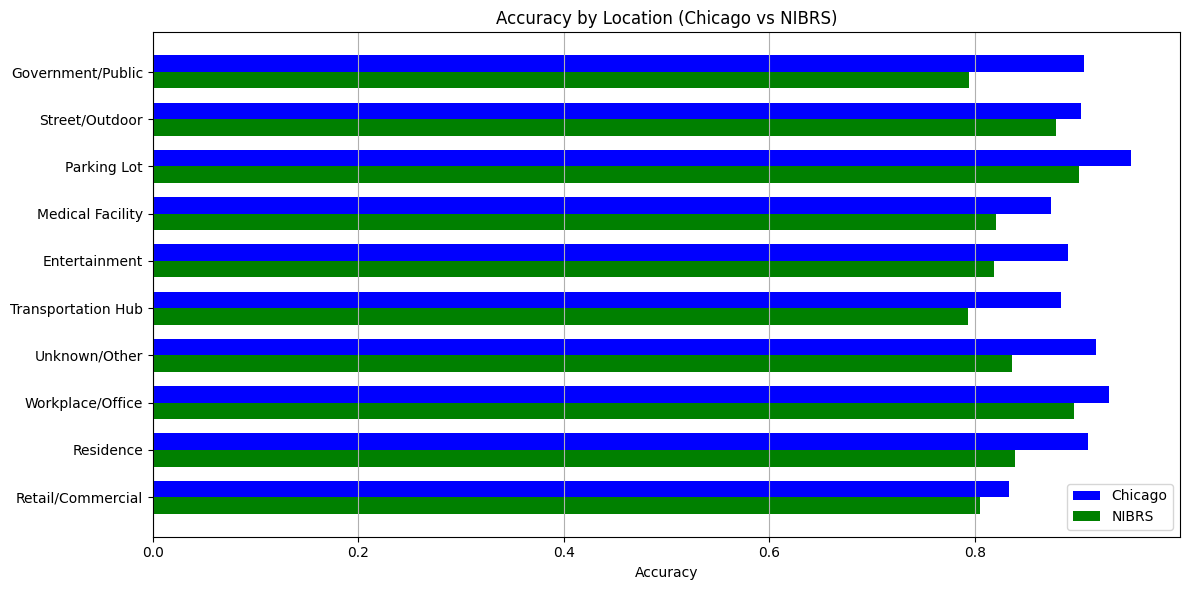

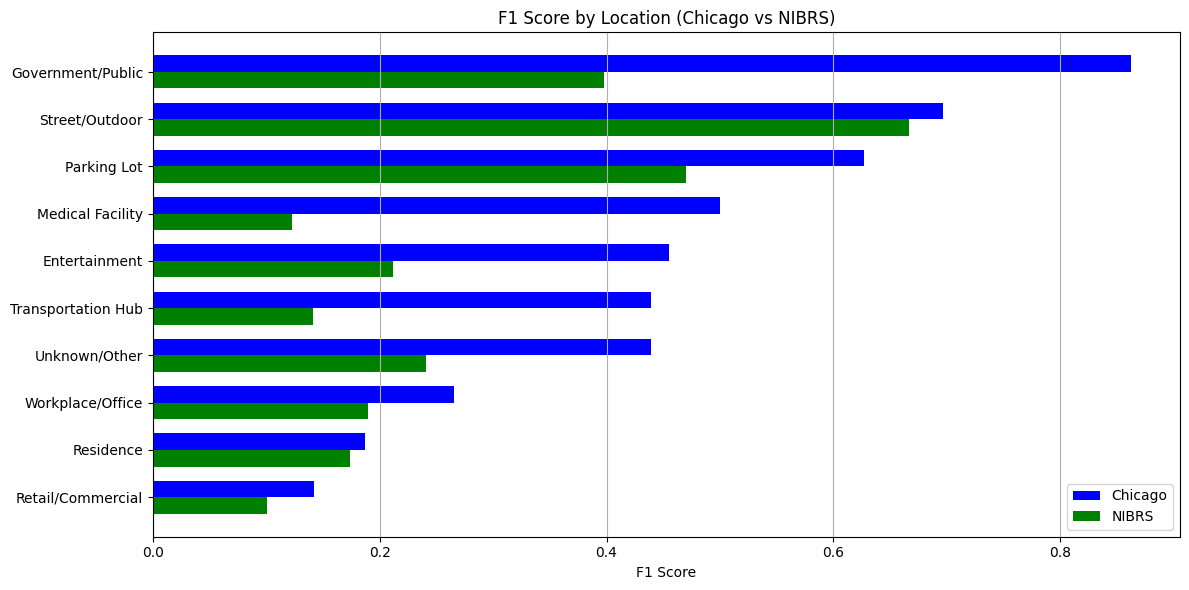

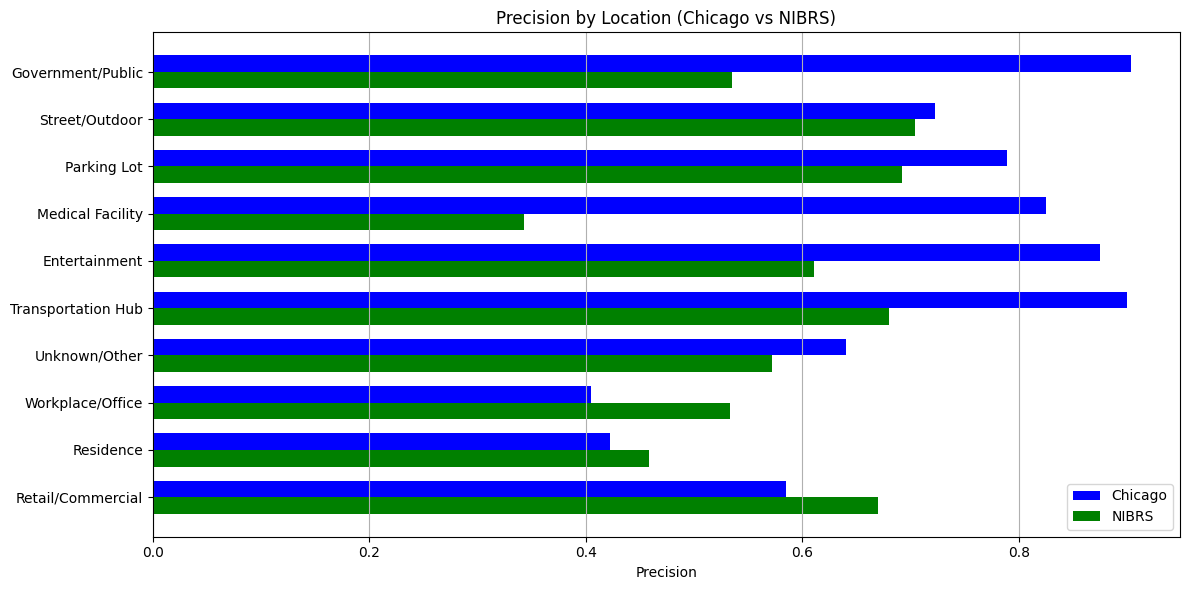

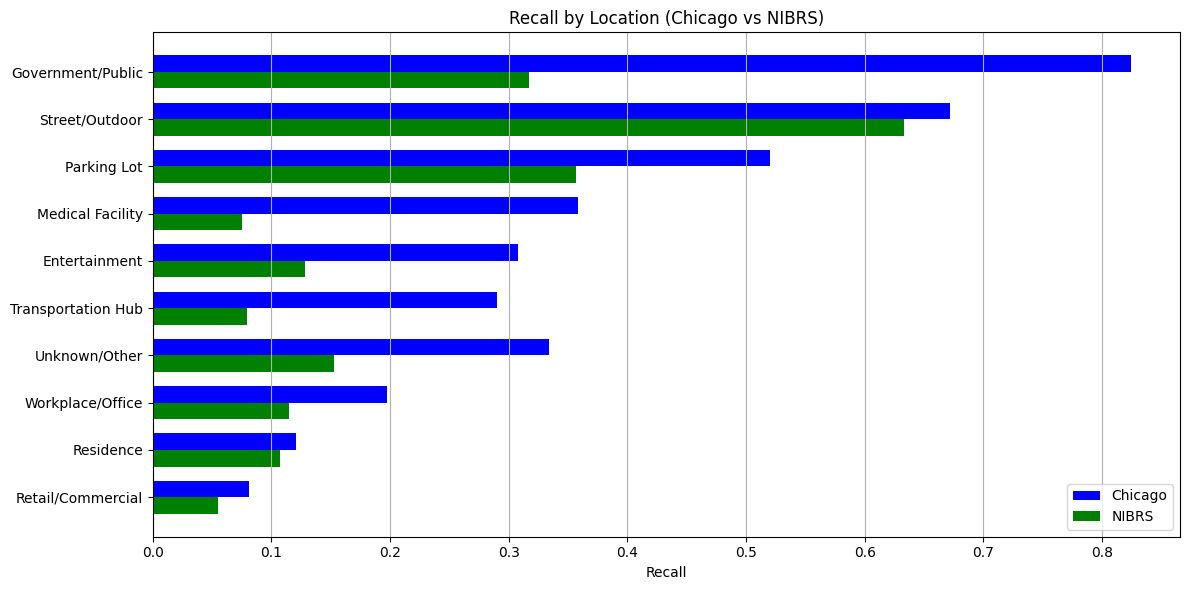

In [41]:
metrics = ['accuracy', 'f1_score', 'precision', 'recall']

for metric in metrics:
    plot_spatial_performance_comparison(
        chicago_spatial_perf,
        NIBRS_spatial_perf,
        metric=metric,
        dataset_names=('Chicago', 'NIBRS')
    )
# plot_spatial_performance_bar(spatial_perf, metric='accuracy')